In [1]:
!pip install timm einops opencv-python tqdm

In [2]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

data_dir = "/kaggle/input/hmdb51/HMDB51"

categories = ['brush_hair', 'cartwheel', 'catch', 'chew', 'clap', 'climb', 'climb_stairs', 'dive', 
              'draw_sword', 'dribble', 'drink', 'eat', 'fall_floor', 'fencing', 'flic_flac', 'golf', 
              'handstand', 'hit', 'hug', 'jump', 'kick', 'kick_ball', 'kiss', 'laugh', 'pick', 'pour', 
              'pullup', 'punch', 'push', 'pushup', 'ride_bike', 'ride_horse', 'run', 'shake_hands', 
              'shoot_ball', 'shoot_bow', 'shoot_gun', 'sit', 'situp', 'smile', 'smoke', 'somersault', 
              'stand', 'swing_baseball', 'sword', 'sword_exercise', 'talk', 'throw', 'turn', 'walk', 'wave']

category_to_label = {category: idx for idx, category in enumerate(categories)}

In [3]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomRotation(10),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

In [4]:
class HMDB51FrameDataset(Dataset):
    def __init__(self, data_dir, categories, transform=None, frames_per_clip=16):
        self.data_dir = data_dir
        self.categories = categories
        self.transform = transform
        self.frames_per_clip = frames_per_clip
        self.data = []
        self.labels = []
        self._load_data()

    def _load_data(self):
        for category in self.categories:
            category_path = os.path.join(self.data_dir, category)
            if not os.path.exists(category_path):
                continue

            for subdir in os.listdir(category_path):
                subdir_path = os.path.join(category_path, subdir)
                if not os.path.isdir(subdir_path):
                    continue

                frame_files = sorted(os.listdir(subdir_path), key=lambda x: int(x.split('.')[0]))
                frame_paths = [os.path.join(subdir_path, frame) for frame in frame_files if frame.endswith(('.jpg', '.png'))]

                if len(frame_paths) == 0:
                    continue

                selected_frames = self._sample_frames(frame_paths)
                self.data.append(selected_frames)
                self.labels.append(category_to_label[category])

    def _sample_frames(self, frame_paths):
        num_frames = len(frame_paths)
        if num_frames >= self.frames_per_clip:
            indices = np.linspace(0, num_frames - 1, self.frames_per_clip, dtype=int)
        else:
            indices = np.arange(num_frames).tolist()
            while len(indices) < self.frames_per_clip:
                indices.append(indices[-1])

        selected_frames = []
        for idx in indices:
            img = cv2.imread(frame_paths[idx], cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, (224, 224))
            img = np.expand_dims(img, axis=0)
            selected_frames.append(img)

        return np.array(selected_frames)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_clip = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            video_clip = np.array([self.transform(frame.squeeze(0)) for frame in video_clip])

        return torch.tensor(video_clip, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [5]:
dataset = HMDB51FrameDataset(data_dir, categories, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [6]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

print(f"Dataset Loaded: {len(dataset)} samples")

Dataset Loaded: 6766 samples


In [7]:
import torch
import torch.nn as nn
from einops import rearrange
from timm.models.vision_transformer import Block

class MultiRegionCNN(nn.Module):
    def __init__(self):
        super(MultiRegionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        B, T, C, H, W = x.size()  
        x = x.view(B * T, C, H, W)  
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(B, T, -1, x.size(2), x.size(3))  
        return x 

In [8]:
class TimeSformer(nn.Module):
    def __init__(self, num_frames=16, img_size=56, patch_size=8, embed_dim=768, num_heads=12, depth=12, num_classes=51):
        super(TimeSformer, self).__init__()
        self.num_patches = (img_size // patch_size) ** 2  
        self.patch_dim = patch_size * patch_size * 128  
        self.embed_dim = embed_dim
        self.num_frames = num_frames

        self.patch_embedding = nn.Linear(self.patch_dim, embed_dim)
        
        self.position_embedding = nn.Parameter(torch.zeros(1, self.num_frames * self.num_patches, embed_dim))
        self.temporal_embedding = nn.Parameter(torch.zeros(1, self.num_frames * self.num_patches, embed_dim))

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.dropout = nn.Dropout(0.3)

        self.blocks = nn.ModuleList([Block(embed_dim, num_heads) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)

        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B, T, C, H, W = x.size()

        x = rearrange(x, 'b t c (h p1) (w p2) -> (b t) (h w) (p1 p2 c)', p1=8, p2=8)
        x = x.view(B * T, self.num_patches, self.patch_dim)

        x = self.patch_embedding(x)
        x = x + self.position_embedding[:, :x.shape[1], :]

        x = rearrange(x, '(b t) n d -> b (t n) d', b=B)
        x = x + self.temporal_embedding[:, :x.shape[1], :]  

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = self.dropout(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x[:, 0])  
        x = self.head(x)
        return x

In [9]:
class WTMRNet(nn.Module):
    def __init__(self, num_classes=51):
        super(WTMRNet, self).__init__()
        self.multi_region_cnn = MultiRegionCNN()
        self.timesformer = TimeSformer(num_classes=num_classes)

    def forward(self, x):
        x = self.multi_region_cnn(x)  
        x = self.timesformer(x)  
        return x

In [10]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.amp import GradScaler, autocast  
from torch.optim.lr_scheduler import ReduceLROnPlateau

torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(categories)
model = WTMRNet(num_classes=num_classes).to(device)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-3) 

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

scaler = GradScaler("cuda")

In [12]:
num_epochs = 50

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

accumulation_steps = 2

In [13]:
epochs = []
train_loss = []
val_loss = []
train_acc = []
val_acc = []

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0

    optimizer.zero_grad()
    
    train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
    for batch_idx, (inputs, labels) in enumerate(train_progress):
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        with autocast(device_type="cuda"):  
            outputs = model(inputs)
            loss = criterion(outputs, labels) / accumulation_steps  

        scaler.scale(loss).backward()  

        if (batch_idx + 1) % accumulation_steps == 0:  
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item() * accumulation_steps
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        train_progress.set_postfix(loss=loss.item() * accumulation_steps)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    model.eval()
    val_loss_total = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            with autocast(device_type="cuda"):  
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            val_loss_total += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = val_loss_total / len(val_loader)
    val_accuracy = correct_val / total_val
    epoch_time = time.time() - start_time

    scheduler.step(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {avg_train_loss:.4f} | Train Accuracy: {train_accuracy:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Accuracy: {val_accuracy:.4f} | "
          f"Time: {epoch_time:.2f}s")
    
    epochs.append(epoch + 1)
    train_loss.append(avg_train_loss)
    val_loss.append(avg_val_loss)
    train_acc.append(train_accuracy)
    val_acc.append(val_accuracy)

import torch
model_save_path = "/kaggle/working/WTMRNet2_HMDB51.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model training complete and saved at: {model_save_path}")

from IPython.display import FileLink
FileLink(model_save_path)

Epoch 1/50: 100%|██████████| 1353/1353 [05:56<00:00,  3.79it/s, loss=3.98]


Epoch 1/50: Train Loss: 3.8639 | Train Accuracy: 0.0693 | Val Loss: 3.7396 | Val Accuracy: 0.0886 | Time: 384.44s


Epoch 2/50: 100%|██████████| 1353/1353 [06:01<00:00,  3.74it/s, loss=3.46]


Epoch 2/50: Train Loss: 3.7299 | Train Accuracy: 0.0767 | Val Loss: 3.7284 | Val Accuracy: 0.0672 | Time: 389.84s


Epoch 3/50: 100%|██████████| 1353/1353 [06:01<00:00,  3.75it/s, loss=3.16]


Epoch 3/50: Train Loss: 3.6748 | Train Accuracy: 0.0809 | Val Loss: 3.6160 | Val Accuracy: 0.0908 | Time: 389.15s


Epoch 4/50: 100%|██████████| 1353/1353 [05:59<00:00,  3.76it/s, loss=3.27]


Epoch 4/50: Train Loss: 3.6071 | Train Accuracy: 0.0843 | Val Loss: 3.5568 | Val Accuracy: 0.0820 | Time: 387.61s


Epoch 5/50: 100%|██████████| 1353/1353 [06:00<00:00,  3.76it/s, loss=2.74]


Epoch 5/50: Train Loss: 3.5014 | Train Accuracy: 0.1001 | Val Loss: 3.5494 | Val Accuracy: 0.0990 | Time: 388.13s


Epoch 6/50: 100%|██████████| 1353/1353 [05:59<00:00,  3.76it/s, loss=3.47]


Epoch 6/50: Train Loss: 3.4210 | Train Accuracy: 0.1116 | Val Loss: 3.4434 | Val Accuracy: 0.1130 | Time: 388.00s


Epoch 7/50: 100%|██████████| 1353/1353 [05:59<00:00,  3.76it/s, loss=3.8] 


Epoch 7/50: Train Loss: 3.3395 | Train Accuracy: 0.1207 | Val Loss: 3.4238 | Val Accuracy: 0.1189 | Time: 387.34s


Epoch 8/50: 100%|██████████| 1353/1353 [05:59<00:00,  3.76it/s, loss=3.08]


Epoch 8/50: Train Loss: 3.2533 | Train Accuracy: 0.1426 | Val Loss: 3.3338 | Val Accuracy: 0.1329 | Time: 387.80s


Epoch 9/50: 100%|██████████| 1353/1353 [05:59<00:00,  3.76it/s, loss=2.31]


Epoch 9/50: Train Loss: 3.1572 | Train Accuracy: 0.1578 | Val Loss: 3.2263 | Val Accuracy: 0.1573 | Time: 387.61s


Epoch 10/50: 100%|██████████| 1353/1353 [05:59<00:00,  3.76it/s, loss=3.63]


Epoch 10/50: Train Loss: 3.0899 | Train Accuracy: 0.1731 | Val Loss: 3.1530 | Val Accuracy: 0.1706 | Time: 387.60s


Epoch 11/50: 100%|██████████| 1353/1353 [06:00<00:00,  3.76it/s, loss=4.25] 


Epoch 11/50: Train Loss: 2.9701 | Train Accuracy: 0.2095 | Val Loss: 3.1266 | Val Accuracy: 0.1832 | Time: 388.23s


Epoch 12/50: 100%|██████████| 1353/1353 [06:01<00:00,  3.74it/s, loss=3.4] 


Epoch 12/50: Train Loss: 2.8863 | Train Accuracy: 0.2225 | Val Loss: 3.0205 | Val Accuracy: 0.2046 | Time: 389.60s


Epoch 13/50: 100%|██████████| 1353/1353 [06:00<00:00,  3.75it/s, loss=2.55]


Epoch 13/50: Train Loss: 2.7942 | Train Accuracy: 0.2435 | Val Loss: 3.0831 | Val Accuracy: 0.2090 | Time: 389.06s


Epoch 14/50: 100%|██████████| 1353/1353 [06:01<00:00,  3.74it/s, loss=2.91] 


Epoch 14/50: Train Loss: 2.6835 | Train Accuracy: 0.2672 | Val Loss: 3.0085 | Val Accuracy: 0.2245 | Time: 389.43s


Epoch 15/50: 100%|██████████| 1353/1353 [06:01<00:00,  3.74it/s, loss=3.36] 


Epoch 15/50: Train Loss: 2.5846 | Train Accuracy: 0.2914 | Val Loss: 3.0252 | Val Accuracy: 0.2223 | Time: 389.60s


Epoch 16/50: 100%|██████████| 1353/1353 [06:01<00:00,  3.74it/s, loss=2.72] 


Epoch 16/50: Train Loss: 2.4773 | Train Accuracy: 0.3130 | Val Loss: 2.8894 | Val Accuracy: 0.2541 | Time: 389.96s


Epoch 17/50: 100%|██████████| 1353/1353 [06:01<00:00,  3.74it/s, loss=2.64] 


Epoch 17/50: Train Loss: 2.3695 | Train Accuracy: 0.3465 | Val Loss: 2.8661 | Val Accuracy: 0.2422 | Time: 389.69s


Epoch 18/50: 100%|██████████| 1353/1353 [06:01<00:00,  3.74it/s, loss=1.65] 


Epoch 18/50: Train Loss: 2.2874 | Train Accuracy: 0.3561 | Val Loss: 2.8468 | Val Accuracy: 0.2644 | Time: 389.93s


Epoch 19/50: 100%|██████████| 1353/1353 [06:01<00:00,  3.74it/s, loss=1.38] 


Epoch 19/50: Train Loss: 2.1688 | Train Accuracy: 0.3923 | Val Loss: 2.7713 | Val Accuracy: 0.2851 | Time: 389.61s


Epoch 20/50: 100%|██████████| 1353/1353 [06:01<00:00,  3.74it/s, loss=3.57] 


Epoch 20/50: Train Loss: 2.0726 | Train Accuracy: 0.4178 | Val Loss: 2.8399 | Val Accuracy: 0.2799 | Time: 389.84s


Epoch 21/50: 100%|██████████| 1353/1353 [06:01<00:00,  3.74it/s, loss=2.22] 


Epoch 21/50: Train Loss: 1.9654 | Train Accuracy: 0.4372 | Val Loss: 2.6783 | Val Accuracy: 0.2925 | Time: 389.54s


Epoch 22/50: 100%|██████████| 1353/1353 [06:01<00:00,  3.74it/s, loss=0.461]


Epoch 22/50: Train Loss: 1.8736 | Train Accuracy: 0.4601 | Val Loss: 2.7257 | Val Accuracy: 0.3109 | Time: 389.65s


Epoch 23/50: 100%|██████████| 1353/1353 [06:01<00:00,  3.74it/s, loss=1.26] 


Epoch 23/50: Train Loss: 1.7968 | Train Accuracy: 0.4758 | Val Loss: 2.6853 | Val Accuracy: 0.3161 | Time: 389.82s


Epoch 24/50: 100%|██████████| 1353/1353 [06:01<00:00,  3.74it/s, loss=2.06] 


Epoch 24/50: Train Loss: 1.6520 | Train Accuracy: 0.5183 | Val Loss: 2.6729 | Val Accuracy: 0.3316 | Time: 389.77s


Epoch 25/50: 100%|██████████| 1353/1353 [06:01<00:00,  3.75it/s, loss=1.34] 


Epoch 25/50: Train Loss: 1.6098 | Train Accuracy: 0.5225 | Val Loss: 2.5329 | Val Accuracy: 0.3656 | Time: 389.31s


Epoch 26/50: 100%|██████████| 1353/1353 [06:01<00:00,  3.74it/s, loss=0.802] 


Epoch 26/50: Train Loss: 1.5142 | Train Accuracy: 0.5486 | Val Loss: 2.6303 | Val Accuracy: 0.3567 | Time: 389.81s


Epoch 27/50: 100%|██████████| 1353/1353 [06:01<00:00,  3.74it/s, loss=2.02]  


Epoch 27/50: Train Loss: 1.3975 | Train Accuracy: 0.5831 | Val Loss: 2.5394 | Val Accuracy: 0.3781 | Time: 389.67s


Epoch 28/50: 100%|██████████| 1353/1353 [06:01<00:00,  3.74it/s, loss=0.856] 


Epoch 28/50: Train Loss: 1.3564 | Train Accuracy: 0.5820 | Val Loss: 2.6078 | Val Accuracy: 0.3671 | Time: 390.03s


Epoch 29/50: 100%|██████████| 1353/1353 [06:00<00:00,  3.75it/s, loss=1.7]  


Epoch 29/50: Train Loss: 1.2278 | Train Accuracy: 0.6131 | Val Loss: 2.6533 | Val Accuracy: 0.3545 | Time: 389.20s


Epoch 30/50: 100%|██████████| 1353/1353 [06:00<00:00,  3.75it/s, loss=1.06]  


Epoch 30/50: Train Loss: 1.1902 | Train Accuracy: 0.6388 | Val Loss: 2.6523 | Val Accuracy: 0.3885 | Time: 389.10s


Epoch 31/50: 100%|██████████| 1353/1353 [06:00<00:00,  3.75it/s, loss=0.654] 


Epoch 31/50: Train Loss: 1.1400 | Train Accuracy: 0.6458 | Val Loss: 2.6660 | Val Accuracy: 0.3936 | Time: 388.96s


Epoch 32/50: 100%|██████████| 1353/1353 [06:01<00:00,  3.75it/s, loss=0.384]  


Epoch 32/50: Train Loss: 0.8139 | Train Accuracy: 0.7520 | Val Loss: 2.5901 | Val Accuracy: 0.4269 | Time: 389.21s


Epoch 33/50: 100%|██████████| 1353/1353 [06:00<00:00,  3.75it/s, loss=0.87]   


Epoch 33/50: Train Loss: 0.6902 | Train Accuracy: 0.7929 | Val Loss: 2.5473 | Val Accuracy: 0.4210 | Time: 388.98s


Epoch 34/50: 100%|██████████| 1353/1353 [06:00<00:00,  3.75it/s, loss=1.88]  


Epoch 34/50: Train Loss: 0.6150 | Train Accuracy: 0.8110 | Val Loss: 2.6455 | Val Accuracy: 0.4357 | Time: 388.79s


Epoch 35/50: 100%|██████████| 1353/1353 [06:01<00:00,  3.75it/s, loss=1.11]   


Epoch 35/50: Train Loss: 0.5947 | Train Accuracy: 0.8197 | Val Loss: 2.6034 | Val Accuracy: 0.4321 | Time: 389.21s


Epoch 36/50: 100%|██████████| 1353/1353 [06:01<00:00,  3.75it/s, loss=0.724]  


Epoch 36/50: Train Loss: 0.5308 | Train Accuracy: 0.8387 | Val Loss: 2.7218 | Val Accuracy: 0.4254 | Time: 389.08s


Epoch 37/50: 100%|██████████| 1353/1353 [06:00<00:00,  3.75it/s, loss=0.265]  


Epoch 37/50: Train Loss: 0.4918 | Train Accuracy: 0.8453 | Val Loss: 2.7214 | Val Accuracy: 0.4380 | Time: 388.92s


Epoch 38/50: 100%|██████████| 1353/1353 [06:00<00:00,  3.76it/s, loss=0.00258]


Epoch 38/50: Train Loss: 0.3592 | Train Accuracy: 0.8954 | Val Loss: 2.7620 | Val Accuracy: 0.4527 | Time: 388.25s


Epoch 39/50: 100%|██████████| 1353/1353 [05:59<00:00,  3.76it/s, loss=0.105]  


Epoch 39/50: Train Loss: 0.2842 | Train Accuracy: 0.9159 | Val Loss: 2.7848 | Val Accuracy: 0.4513 | Time: 388.01s


Epoch 40/50: 100%|██████████| 1353/1353 [06:00<00:00,  3.75it/s, loss=0.06]   


Epoch 40/50: Train Loss: 0.2634 | Train Accuracy: 0.9228 | Val Loss: 2.8265 | Val Accuracy: 0.4586 | Time: 388.82s


Epoch 41/50: 100%|██████████| 1353/1353 [06:00<00:00,  3.75it/s, loss=0.221]  


Epoch 41/50: Train Loss: 0.2372 | Train Accuracy: 0.9311 | Val Loss: 2.9049 | Val Accuracy: 0.4461 | Time: 389.05s


Epoch 42/50: 100%|██████████| 1353/1353 [05:59<00:00,  3.76it/s, loss=0.184]  


Epoch 42/50: Train Loss: 0.2117 | Train Accuracy: 0.9398 | Val Loss: 2.9565 | Val Accuracy: 0.4439 | Time: 387.95s


Epoch 43/50: 100%|██████████| 1353/1353 [05:59<00:00,  3.76it/s, loss=0.0018] 


Epoch 43/50: Train Loss: 0.2055 | Train Accuracy: 0.9374 | Val Loss: 2.9116 | Val Accuracy: 0.4579 | Time: 387.81s


Epoch 44/50: 100%|██████████| 1353/1353 [05:59<00:00,  3.76it/s, loss=0.0663]  


Epoch 44/50: Train Loss: 0.1407 | Train Accuracy: 0.9592 | Val Loss: 2.9215 | Val Accuracy: 0.4572 | Time: 387.70s


Epoch 45/50: 100%|██████████| 1353/1353 [06:00<00:00,  3.76it/s, loss=0.00881]


Epoch 45/50: Train Loss: 0.1175 | Train Accuracy: 0.9662 | Val Loss: 2.9988 | Val Accuracy: 0.4594 | Time: 388.44s


Epoch 46/50: 100%|██████████| 1353/1353 [05:59<00:00,  3.76it/s, loss=0.0161]  


Epoch 46/50: Train Loss: 0.1077 | Train Accuracy: 0.9706 | Val Loss: 3.0608 | Val Accuracy: 0.4505 | Time: 387.77s


Epoch 47/50: 100%|██████████| 1353/1353 [05:59<00:00,  3.76it/s, loss=0.00741] 


Epoch 47/50: Train Loss: 0.0929 | Train Accuracy: 0.9758 | Val Loss: 3.0088 | Val Accuracy: 0.4668 | Time: 387.65s


Epoch 48/50: 100%|██████████| 1353/1353 [05:59<00:00,  3.77it/s, loss=0.055]   


Epoch 48/50: Train Loss: 0.0884 | Train Accuracy: 0.9773 | Val Loss: 3.1084 | Val Accuracy: 0.4527 | Time: 387.51s


Epoch 49/50: 100%|██████████| 1353/1353 [05:59<00:00,  3.76it/s, loss=0.00768] 


Epoch 49/50: Train Loss: 0.0785 | Train Accuracy: 0.9804 | Val Loss: 3.1084 | Val Accuracy: 0.4483 | Time: 388.19s


Epoch 50/50: 100%|██████████| 1353/1353 [05:59<00:00,  3.77it/s, loss=0.00262] 


Epoch 50/50: Train Loss: 0.0665 | Train Accuracy: 0.9841 | Val Loss: 3.0803 | Val Accuracy: 0.4557 | Time: 387.61s
Model training complete and saved at: /kaggle/working/WTMRNet2_HMDB51.pth


/kaggle/working/WTMRNet2_HMDB51.pth

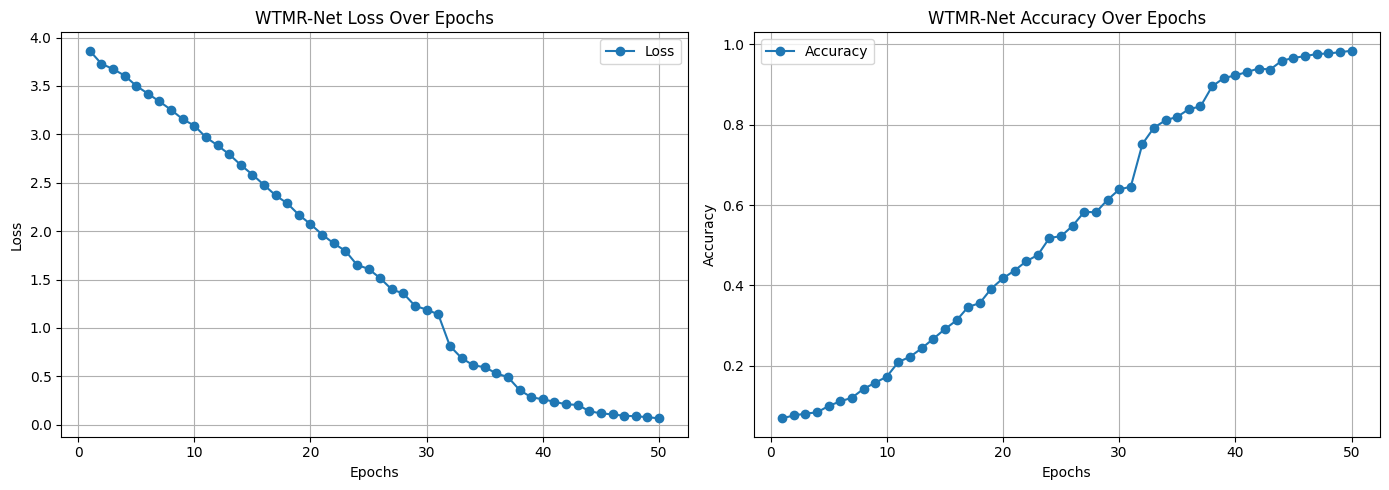

In [18]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].plot(epochs, train_loss, label="Loss", marker='o', linestyle='-')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("WTMR-Net Loss Over Epochs")
ax[0].legend()
ax[0].grid()

ax[1].plot(epochs, train_acc, label="Accuracy", marker='o', linestyle='-')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("WTMR-Net Accuracy Over Epochs")
ax[1].legend()
ax[1].grid()

plt.tight_layout()
plt.show()